In [1]:
from stockfish import Stockfish
import chess

stockfish_path = "/Users/benitorusconi/Documents/CDS/05_HS23/Reinforcement Learning (cds-117)/engine/stockfish"
stockfish = Stockfish(path=stockfish_path)

def print_board(board):
    print(board)

def play_game():
    board = chess.Board()

    print("Chess game against Stockfish\n")

    while not board.is_game_over():
        print_board(board)

        # Player's move
        player_move = input("Your move (in algebraic notation): ")
        if chess.Move.from_uci(player_move) in board.legal_moves:
            board.push_uci(player_move)
        else:
            print("Invalid move. Try again.")
            continue

        if board.is_game_over():
            break

        # Stockfish's move
        stockfish.set_fen_position(board.fen())
        stockfish_move = stockfish.get_best_move()
        print("Stockfish's move:", stockfish_move)
        board.push_uci(stockfish_move)

    print("\nGame Over")
    print("Result:", board.result())

# Play the game
#play_game()


In [ ]:
from stockfish import Stockfish
import chess
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import display, HTML
import chess.svg

stockfish_path = "/Users/benitorusconi/Documents/CDS/05_HS23/Reinforcement Learning (cds-117)/engine/stockfish"
stockfish = Stockfish(path=stockfish_path)

learning_rate = 0.01
discount_factor = 0.99
exploration_prob = 0.1

state_space_size = 64
action_space_size = 4096
q_table = np.zeros((state_space_size, action_space_size))

model = Sequential([
    Dense(64, input_shape=(state_space_size,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1028, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(action_space_size, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

def state_to_index(board):
    return hash(board.fen()) % state_space_size

def choose_action(board):
    if np.random.rand() < exploration_prob:
        return np.random.choice(list(board.legal_moves))
    else:
        state_index = state_to_index(board)
        legal_moves_list = list(board.legal_moves)
        if not legal_moves_list:
            return chess.Move.null()
        best_move_index = np.argmax(q_table[state_index])
        best_move_uci = legal_moves_list[min(best_move_index, len(legal_moves_list)-1)].uci()
        return chess.Move.from_uci(best_move_uci)

def update_q_table(state, action, reward, next_state):
    state_index = state_to_index(state)
    next_state_index = state_to_index(next_state)
    action_index = list(state.legal_moves).index(action)
    best_next_action = np.argmax(q_table[next_state_index])
    q_table[state_index, action_index] += learning_rate * (
        reward + discount_factor * q_table[next_state_index, best_next_action] - q_table[state_index, action_index]
    )

def display_chess_board(board):
    return display(HTML(chess.svg.board(board=board, size=400)))

def play_game():
    board = chess.Board()
    game_states = []

    while not board.is_game_over():
        state = board.copy()
        game_states.append(state.copy())

        rl_move = choose_action(board)
        if rl_move in board.legal_moves:
            board.push(rl_move)
        else:
            print("Invalid move. Try again.")
            continue

        reward = 0

        if board.is_game_over():
            break

        stockfish.set_fen_position(board.fen())
        stockfish_move_uci = stockfish.get_best_move()
        stockfish_move = chess.Move.from_uci(stockfish_move_uci)
        next_state = board.copy()
        board.push(stockfish_move)

        if next_state.is_check():
            reward = 0.5

        if board.result() == "1-0":
            reward = 1000 # Win
        elif board.result() == "0-1":
            reward = -1000  # Loss
        elif board.result() == "1/2-1/2":
            reward = 100  # Draw

        # Capture rewards based on piece values
        if board.is_capture(rl_move):
            captured_piece_value = piece_value(board.piece_at(rl_move.to_square))
            reward += captured_piece_value

        if board.is_capture(stockfish_move):
            captured_piece_value = piece_value(board.piece_at(stockfish_move.to_square))
            reward -= captured_piece_value

        update_q_table(state, rl_move, reward, next_state)

    game_states.append(board.copy())
    return game_states, board.result(), reward

def piece_value(piece):
    # Assign values to pieces
    if piece is None:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 1
    elif piece.piece_type == chess.KNIGHT:
        return 3
    elif piece.piece_type == chess.BISHOP:
        return 3
    elif piece.piece_type == chess.ROOK:
        return 5
    elif piece.piece_type == chess.QUEEN:
        return 9
    elif piece.piece_type == chess.KING:
        return 100000


log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

num_games = 1
for episode in range(num_games):
    print("Game:", episode)
    total_reward = 0
    steps = 0
    game_states, result, reward = play_game()
    total_reward += reward
    steps += len(game_states)

    with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.scalar('Total Reward', total_reward, step=episode)
        tf.summary.scalar('Steps', steps, step=episode)
        tf.summary.flush()

        for layer in model.layers:
            for weight in layer.weights:
                tf.summary.histogram(weight.name, weight, step=episode)

    if episode == num_games - 1:
        # Display the last game
        for state in game_states:
            display_chess_board(state)


CNN Version

Game: 0
1/1 [==============================] - 0s 10ms/step


/var/folders/wh/6vs39mgs1910xc7nplcv5b000000gn/T/ipykernel_9608/1093460025.py:68: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return hash(board_array.tostring()) % state_space_size[0]


1/1 [==============================] - 0s 11ms/step
Total Reward for Game 0: 0.5
Game: 1
1/1 [==============================] - 0s 21ms/step
Total Reward for Game 1: -0.8
Game: 2
1/1 [==============================] - 0s 27ms/step
Total Reward for Game 2: -0.7
Game: 3
1/1 [==============================] - 0s 22ms/step
Total Reward for Game 3: -0.8
Average Total Reward: -0.45
Final Position FEN: 8/8/8/8/8/8/4k3/1K6 w - - 0 43



Results Summary:
White Wins: 0
Black Wins: 0
Draws: 4


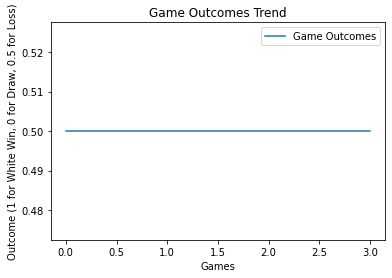

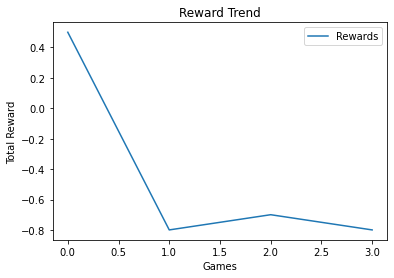

In [5]:
from collections import deque
import random
from stockfish import Stockfish
import chess
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import display, HTML
import chess.svg
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

# Path to Stockfish engine
stockfish_path = "/Users/benitorusconi/Documents/CDS/05_HS23/Reinforcement Learning (cds-117)/engine/stockfish"
stockfish = Stockfish(path=stockfish_path)

# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_prob = 0.01

# Neural Network Architecture
state_space_size = (8, 8, 12)  # 8x8 board with 12 channels (one for each piece type and color)
action_space_size = 4096

# Initialize a deque for experience replay
experience_replay_buffer = deque(maxlen=10000)

# Neural Network Model alpha zero


# Input layer
input_layer = Input(shape=state_space_size)

# Contracting path
conv1 = Conv2D(64, (11, 11), activation='relu', padding='same')(input_layer)
maxpool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (7, 7), activation='relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxpool2)

# Expansive path
upconv1 = Conv2D(128, (7, 7), activation='relu', padding='same')(UpSampling2D((2, 2))(conv3))
concat1 = Concatenate()([conv2, upconv1])

upconv2 = Conv2D(64, (11, 11), activation='relu', padding='same')(UpSampling2D((2, 2))(concat1))
concat2 = Concatenate()([conv1, upconv2])

# Output layer
output_layer = Conv2D(1, (1, 1), activation='linear', padding='same')(concat2)

# Flatten and Dense layers for final prediction
flatten_layer = Flatten()(output_layer)
final_output = Dense(action_space_size, activation='linear')(flatten_layer)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=final_output)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

def state_to_index(board):
    board_array = np.array(board_to_input_array(board))
    return hash(board_array.tostring()) % state_space_size[0]

def board_to_input_array(board):
    board_array = np.zeros((8, 8, 12), dtype=np.uint8)
    piece_mapping = {'r': 0, 'n': 1, 'b': 2, 'q': 3, 'k': 4, 'p': 5, 'R': 6, 'N': 7, 'B': 8, 'Q': 9, 'K': 10, 'P': 11}
    #normalize piece values

    
    for square, piece in board.piece_map().items():
        piece_type = piece_mapping[piece.symbol()]
        color = int(piece.color)
        board_array[square // 8, square % 8, piece_type] = color + 1  # Use 0 for empty squares

    return board_array

def choose_action(board):
    if np.random.rand() < exploration_prob:
        return np.random.choice(list(board.legal_moves))
    else:
        state_index = state_to_index(board)
        legal_moves_list = list(board.legal_moves)
        if not legal_moves_list:
            return chess.Move.null()
        q_values = model.predict(np.array([board_to_input_array(board)]))[0]
        best_move_index = np.argmax(q_values)
        best_move_uci = legal_moves_list[min(best_move_index, len(legal_moves_list)-1)].uci()
        return chess.Move.from_uci(best_move_uci)
    



def piece_coordination_reward(board, current_move):
    # Evaluate piece coordination as the average number of legal moves for all pieces before and after the move
    total_moves_before = 0
    total_moves_after = 0
    total_pieces = 0

    for square, piece in board.piece_map().items():
        if piece.color == board.turn:
            legal_moves_before = list(board.legal_moves)
            total_moves_before += len(legal_moves_before)

            # Make a hypothetical move and evaluate legal moves after the move
            board_copy = board.copy()
            board_copy.push(current_move)
            legal_moves_after = list(board_copy.legal_moves)
            total_moves_after += len(legal_moves_after)

            total_pieces += 1

    # Calculate the change in total moves
    moves_change = total_moves_after - total_moves_before

    # Normalize the reward to be between -1 and 1
    max_moves = max(total_moves_before / total_pieces, 1)
    normalized_reward = (total_moves_before / total_pieces - 1) / max_moves

    # Adjust the reward based on the change in total moves
    reward_adjustment = 0.1
    normalized_reward += reward_adjustment * moves_change / max_moves

    # Scale the reward between -1 and 1
    normalized_reward = max(min(normalized_reward, 1), -1)

    #print("Piece coordination reward:", normalized_reward)
    #print("Total moves before:", total_moves_before)
    #print("Total moves after:", total_moves_after)

    return normalized_reward



def update_q_table(state, action, reward, next_state):
    state_index = state_to_index(state)
    next_state_index = state_to_index(next_state)
    action_index = list(state.legal_moves).index(action)
    
    # Calculate the additional rewards
    piece_coordination_reward_value = piece_coordination_reward(state, action)

    # Combine the rewards with weights (you can adjust the weights as needed)
    #total_reward = reward + 0.01 * piece_coordination_reward_value
    total_reward = reward

    # Store the experience in the replay buffer
    experience_replay_buffer.append((state_index, action_index, total_reward, next_state_index))

    # Sample a batch from the replay buffer for training
    batch_size = min(len(experience_replay_buffer), 8)
    if batch_size > 0:
        batch = np.array(random.sample(experience_replay_buffer, batch_size))
        states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 0]])
        next_states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 3]])
        q_values = model.predict(states)
        next_q_values = model.predict(next_states)
        
        for i in range(batch_size):
            action_idx = int(batch[i, 1])  # Cast to integer
            q_values[i, action_idx] += learning_rate * (
                batch[i, 2] + discount_factor * np.max(next_q_values[i]) - q_values[i, action_idx]
            )
        
        # Train the model on the batch
        model.train_on_batch(states, q_values)


def display_chess_board(board):
    return display(HTML(chess.svg.board(board=board, size=400)))

def play_game():
    fen_starting_position = "4k3/8/8/8/8/8/3R4/3RRK2 w - - 0 1"

    board = chess.Board(fen_starting_position)
    game_states = []
    total_reward = 0  # Initialize total_reward

    while not board.is_game_over():
        state = board.copy()
        game_states.append(state.copy())

        rl_move = choose_action(board)
        if rl_move in board.legal_moves:
            board.push(rl_move)
        else:
            print("Invalid move. Try again.")
            continue

        reward = 0

        if board.is_game_over():
            break

        stockfish.set_fen_position(board.fen())
        stockfish_move_uci = stockfish.get_best_move()
        stockfish_move = chess.Move.from_uci(stockfish_move_uci)
        next_state = board.copy()
        board.push(stockfish_move)

        if next_state.is_check():
            reward = 0.1

        if board.result() == "1-0":
            reward = 5  # Win
        elif board.result() == "0-1":
            reward = -1  # Loss
        elif board.result() == "1/2-1/2":
            reward = -1  # Draw

        # Capture rewards based on piece values
        if board.is_capture(rl_move):
            captured_piece_value = piece_value(board.piece_at(rl_move.to_square))
            reward += captured_piece_value

        if board.is_capture(stockfish_move):
            captured_piece_value = piece_value(board.piece_at(stockfish_move.to_square))
            reward -= captured_piece_value

        update_q_table(state, rl_move, reward, next_state)
        
        # Accumulate the reward
        total_reward += reward

    game_states.append(board.copy())
    return game_states, board.result(), total_reward  # Return total_reward



def piece_value(piece):
    if piece is None:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 0.1
    elif piece.piece_type == chess.KNIGHT:
        return 0.3
    elif piece.piece_type == chess.BISHOP:
        return 0.3
    elif piece.piece_type == chess.ROOK:
        return 0.5
    elif piece.piece_type == chess.QUEEN:
        return 0.9
    elif piece.piece_type == chess.KING:
        return 0






log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)








num_games = 100
total_rewards = []
results = {"white_wins": 0, "black_wins": 0, "draws": 0}
outcomes = []

# ... (Your existing code above)

# List to store rewards for each game
# ... (Your existing code above)

# List to store rewards for each game
reward_trend = []

for episode in range(num_games):
    print("Game:", episode)
    game_states, result, total_reward = play_game()

    # Append the total reward to the reward trend list
    reward_trend.append(total_reward)

    # Update results based on the game outcome
    if result == "1-0":
        results["white_wins"] += 1
        outcomes.append(1)
    elif result == "0-1":
        results["black_wins"] += 1
        outcomes.append(0)
    elif result == "1/2-1/2":
        results["draws"] += 1
        outcomes.append(0.5)  # Fix here: Append 0.5 for draws

    total_rewards.append(total_reward)
    
    # Display the total reward for each game
    print("Total Reward for Game {}: {}".format(episode, total_reward))

# Display statistics
average_reward = sum(total_rewards) / num_games
print("Average Total Reward:", average_reward)

# Extract the FEN of the final position
final_position_fen = game_states[-1].fen()
print("Final Position FEN:", final_position_fen)

# Display the last game
for state in game_states:
    display_chess_board(state)

# Display results
print("\nResults Summary:")
print("White Wins:", results["white_wins"])
print("Black Wins:", results["black_wins"])
print("Draws:", results["draws"])

# Plot trend lines
plt.plot(outcomes, label="Game Outcomes")
plt.xlabel("Games")
plt.ylabel("Outcome (1 for White Win, 0 for Draw, 0.5 for Loss)")
plt.legend()
plt.title("Game Outcomes Trend")

# Plot rewards
plt.figure()
plt.plot(reward_trend, label="Rewards")
plt.xlabel("Games")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Reward Trend")

plt.show()










